In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle
import copy as cp
from math import *
import datetime as dt
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
#
import scipy
import scipy.integrate as integrate
from scipy.optimize import root
from scipy.optimize import least_squares

In [2]:
# write list to binary file
def write2pickle(file, fname):
    # store list in binary file so 'wb' mode
    with open(fname, 'wb') as f:
        pickle.dump(file, f)
        print('Done writing list into a binary file')

# Read list to memory
def read_pickle(fname):
    # for reading also binary mode is important
    with open(fname, 'rb') as f:
        file = pd.read_pickle(f)
        return file

# Chech directories exit. Create if not
def check_dir_exist(path):
    if not os.path.isdir(path):
        os.makedirs(path, exist_ok=True)

In [3]:
# This is to enable inline displays
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# Plot parameters
rcParams['figure.figsize'] = 6,4

# Seaborn settings for notebook
rc = {'lines.linewidth': 1.,
      'axes.titlesize': 14,
      'axes.labelsize': 14,
      'xtick.labelsize': 10,
      'ytick.labelsize': 10,
      'legend.fontsize': 10,
      'savefig.dpi': 300,
      'axes.facecolor': 'white'}
sns.set_context('notebook', rc=rc)
sns.set_style('ticks', rc=rc)

In [4]:
# Set directories
path = "../data/"

# Set colors
colormap = ['magenta',
           'darkcyan',
           'darkseagreen',
           'green',
           'royalblue',
           'orangered',
           'steelblue',
           'peru',
           'skyblue',
           'firebrick',
           'blue',
           'red']

## Calculate a0 from experiments

In [5]:
print("cell Volume [micro-meters**3] =", 4/3*pi*(22/2)**3)

N_Av = 6.02214076e23 # число Авогадро

# Calc.
atp_dV = 2e-6 # Моль*cell_number (from experiment in 5e5 cells)
# V = 4/3*pi*(22e-6/2)**3*1e-3 * 5e5
print(f"a0 = {N_Av*atp_dV/5e5*1e-9:.3f} mol.*10**9")

cell Volume [micro-meters**3] = 5575.279762570686
a0 = 2408.856 mol.*10**9


# Set model

In [6]:
# Wild type values
awt = 2408e9  # characteristic number of ATP
Lwt = 1064.   # number of LINE-1 in wild type
Swt = 13243.  # number of SINE in wild type

# expected observables under normal conditions:
a0,mq0,cq0,q0,mL0,mS0,cL0,O10,bL0,bS0,L0,S0 = np.array([2.40931696e+12, 1.01120553e+07, 3.86703330e+06, 4.74721425e+09,
       1.31903161e+05, 2.00641730e+08, 2.20941873e+05, 5.74596157e+07,
       4.01203844e+03, 1.16324573e+04, 1.05977067e+03, 1.31865310e+04])

# Steady state reference
y0 = np.array([a0,mq0,cq0,q0,mL0,mS0,cL0,O10,bL0,bS0,L0,S0])

### Constants: ###
Ng       = 3.08e9  # total genome size [bp]
Q        = 3804.   # number of housekeeping genes
nq       = 431.    # median HeLa cell protein length [aa]
nQ       = 1300.   # median HeLa housekeeping gene length [bp]
nL       = 6000.   # LINE-1 length [bp]
nS       = 300.    # SINE length [bp]
Naa      = 5.      # number of ATP molecules for adding a.a. [m.p.c. - mol. per cell]
Nnt      = 15.     # number of ATP molecules for adding nt. [m.p.c.]
tdiv     = 22.*60  # HeLa cell cycle duration, in minutes [min] ( == 1320 min )

### Parameter values: ###
rtot     = 9.5e6   # total number of ribosomes [m.p.c.]
A0       = 1.31e10 # energy supply [m.p.c./min]
Xi_max_L = 840.    # maximal integration elongation rate of one LINE-1 transposon [bp/(m.p.c.*min)]
Xi_max_S = 840.    # maximal integration elongation rate of one SINE transposon [bp/(m.p.c.*min)]
K_Xi_L   = 1.1e7   # integration elongation threshold of LINE-1 transposons [m.p.c.]
K_Xi_S   = 1.1e7   # integration elongation threshold of SINE transposons [m.p.c.]
KL       = 2.24e-3 # association constant of LINE-1 mRNA with ORF1p [1/m.p.c.]
wq       = 4.64    # maximal transcription rate of one gene [m.p.c./min]
wL       = 1.      # maximal transcription rate of one LINE-1 [m.p.c./min]
wS       = 20.     # maximal transcription rate of one SINE [m.p.c./min]
Th_nr_q  = 3.8e9   # transcription threshold of one gene [m.p.c.]
Th_nr_L  = 3.8e9   # transcription threshold of one LINE-1 [m.p.c.]
Th_nr_S  = 3.8e9   # transcription threshold of one SINE [m.p.c.]
gm_max_q = 300.    # maximal translation rate of q-RNA (aa/min) [a.a./(m.p.c.*min)]
gm_max_L = 300.    # maximal translation rate of LINE-1 RNA (aa/min) [a.a./(m.p.c.*min)]
K_gm_q   = 25900.  # translation threshold of one q-RNA [m.p.c.]
K_gm_L   = 25900.  # translation threshold of one LINE-1 RNA [m.p.c.]
k_bq     = 5e-8    # 2.7e-2 # cq complexes binding rate constant (diffusion limit) [1/(m.p.c.*min)]
k_bL     = 5e-8    # 2.7e-2 # cL complexes binding rate constant (diffusion limit) [1/(m.p.c.*min)]
k_uq     = 1e-2    # 1e3 # cq complexes unbinding rate constant
k_uL     = 1e-2    # 1e3 # cL complexes unbinding rate constant
k_subS   = 5e-8    # 6e-8 # bS formation (ORFp2+mS) substitution of mL
k_subL   = 5e-6    # 6e-8 # bL formation (ORFp2+mL) substitution of mS
d_mq     = 1.15e-3 # q-RNAs degradation rate constant [1/min]
d_cq     = 1.55e-3 # cq complexes degradation rate constant [1/min]
d_q      = 5.67e-4 # q proteins degradation rate constant [1/min]
d_mL     = 1.15e-3 # LINE-1 RNAs degradation rate constant [1/min]
d_mS     = 1.15e-3 # ! # SINE RNAs degradation rate constant [1/min]
d_cL     = 1.55e-3 # cL complexes degradation rate constant [1/min]
d_O1     = 5.67e-4 # ORF1p degradation rate constant [1/min]
d_bL     = 5.67e-4 # bL complexes degradation rate constant [1/min]
d_bS     = 5.67e-4 # bS complexes degradation rate constant [1/min]
#
lmd_a    = 2.04e-3 # ATP molecules degradation rate constant [1/min]
lmd_L    = 0.53    # LINE-1 deactivation rate constant [1/min]
lmd_S    = 2.47    # SINE deactivation rate constant [1/min]

# Add some
rib = rtot - cq0 - cL0 # number of free ribosomes
vrepl_max = Nnt*(Ng/tdiv)/0.8
k_vrepl = 0.25*a0

In [7]:
# translation rates:
def vq(cq_, a_):
    return gm_max_q/nq*cq_*a_/(K_gm_q+a_)

def vL(cL_,a_):
    return gm_max_L/(nL/3)*cL_*a_/(K_gm_L+a_)

# integration rates:
def vintL(bL_,O1_,a_):
    return Xi_max_L/nL * bL_*a_/(K_Xi_L+a_)*KL*O1_/(1+KL*O1_)

def vintS(bS_,a_):
    return Xi_max_S/nS * bS_*a_/(K_Xi_S+a_)

# transcription rates:
def om_q(a_):
    return Q*wq*a_/(Th_nr_q+a_)

def om_L(L_,a_):
    return L_*wL*a_/(Th_nr_L+a_)

def om_S(S_,a_):
    return S_*wS*a_/(Th_nr_S+a_)

# replication:
# def vreplf(a_):
#     return vrepl_max*a_/(a_+k_vrepl)

# replication:
def vreplf(a_,bL_,O1_,bS_):
    return Nnt*(Ng/tdiv + vintL(bL_,O1_,a_)*nL + vintS(bS_,a_)*nS)

# ribosomes:
def ribf(cq_,cL_):
    return rtot-cq_-cL_

In [8]:
# Function for integration
def integr_syst(t, y):
    a_,mq_,cq_,q_,mL_,mS_,cL_,O1_,bL_,bS_,L_,S_ = y
    dydt = np.array([A0 - lmd_a*a_ - vreplf(a_,bL_,O1_,bS_) # energy supply + ATP degradation + replication
                   - Nnt * ( om_q(a_)*(nQ) + om_S(S_,a_)*nS + om_L(L_,a_)*nL ) # transcription
                   - Naa * ( vq(cq_,a_)*nq + vL(cL_,a_)*(nL/3) ) # translation
                   - Nnt * ( vintL(bL_,O1_,a_)*nL + vintS(bS_,a_)*nS ), # integration # da/dt
                    om_q(a_) - k_bq*ribf(cq_,cL_)*mq_ + vq(cq_,a_) + k_uq*cq_  - d_mq*mq_, # dmq/dt
                    k_bq*ribf(cq_,cL_)*mq_  - k_uq*cq_ - vq(cq_,a_) - d_cq*cq_, # dcq/dt
                    vq(cq_,a_) - d_q*q_, # dq/dt
                    om_L(L_,a_) - k_bL*ribf(cq_,cL_)*mL_ + k_uL*cL_ + k_subS*mS_*bL_ - k_subL*mL_*bS_ - d_mL*mL_, # dmL/dt
                    om_S(S_,a_) + k_subL*mL_*bS_ - k_subS*mS_*bL_ - d_mS*mS_, # dmS/dt
                    k_bL*ribf(cq_,cL_)*mL_  - k_uL*cL_ - vL(cL_,a_) - d_cL*cL_, # dcL/dt
                    vL(cL_,a_) - vintL(bL_,O1_,a_) - d_O1*O1_, # dO1/dt
                    vL(cL_,a_) + k_subL*mL_*bS_ - vintL(bL_,O1_,a_) - k_subS*mS_*bL_ - d_bL*bL_, # dbL/dt
                    k_subS*mS_*bL_ - k_subL*mL_*bS_ - vintS(bS_,a_) - d_bS*bS_, # dbS/dt
                    vintL(bL_,O1_,a_) - lmd_L*L_, # dL/dt
                    vintS(bS_,a_) - lmd_S*S_]) # dS/dt
    return dydt

In [9]:
# Function for minimization
def solve_syst(y):
    a_,mq_,cq_,q_,mL_,mS_,cL_,O1_,bL_,bS_,L_,S_ = y
    dydt = np.array([A0 - lmd_a*a_ - vreplf(a_,bL_,O1_,bS_) # energy supply + ATP degradation + replication
                   - Nnt * ( om_q(a_)*(nQ) + om_S(S_,a_)*nS + om_L(L_,a_)*nL ) # transcription
                   - Naa * ( vq(cq_,a_)*nq + vL(cL_,a_)*(nL/3) ) # translation
                   - Nnt * ( vintL(bL_,O1_,a_)*nL + vintS(bS_,a_)*nS ), # integration # da/dt
                    om_q(a_) - k_bq*ribf(cq_,cL_)*mq_ + vq(cq_,a_) + k_uq*cq_  - d_mq*mq_, # dmq/dt
                    k_bq*ribf(cq_,cL_)*mq_  - k_uq*cq_ - vq(cq_,a_) - d_cq*cq_, # dcq/dt
                    vq(cq_,a_) - d_q*q_, # dq/dt
                    om_L(L_,a_) - k_bL*ribf(cq_,cL_)*mL_ + k_uL*cL_ + k_subS*mS_*bL_ - k_subL*mL_*bS_ - d_mL*mL_, # dmL/dt
                    om_S(S_,a_) + k_subL*mL_*bS_ - k_subS*mS_*bL_ - d_mS*mS_, # dmS/dt
                    k_bL*ribf(cq_,cL_)*mL_  - k_uL*cL_ - vL(cL_,a_) - d_cL*cL_, # dcL/dt
                    vL(cL_,a_) - vintL(bL_,O1_,a_) - d_O1*O1_, # dO1/dt
                    vL(cL_,a_) + k_subL*mL_*bS_ - vintL(bL_,O1_,a_) - k_subS*mS_*bL_ - d_bL*bL_, # dbL/dt
                    k_subS*mS_*bL_ - k_subL*mL_*bS_ - vintS(bS_,a_) - d_bS*bS_, # dbS/dt
                    vintL(bL_,O1_,a_) - lmd_L*L_, # dL/dt
                    vintS(bS_,a_) - lmd_S*S_]) # dS/dt
    return dydt

# # Function for root finding
# def solve_syst(y):
#     a_ = a0
#     L_ = L0
#     S_ = S0
#     lmd_a,mq_,cq_,q_,mL_,mS_,cL_,O1_,bL_,bS_,lmd_L, lmd_S = y
#     dydt = np.array([A0 - lmd_a*a_ - vreplf(a_,bL_,O1_,bS_) # energy supply + ATP degradation + replication
#                    - Nnt * ( om_q(a_)*(nQ) + om_S(S_,a_)*nS + om_L(L_,a_)*nL ) # transcription
#                    - Naa * ( vq(cq_,a_)*nq + vL(cL_,a_)*(nL/3) ) # translation
#                    - Nnt * ( vintL(bL_,O1_,a_)*nL + vintS(bS_,a_)*nS ), # integration # da/dt
#                     om_q(a_) - k_bq*ribf(cq_,cL_)*mq_ + vq(cq_,a_) + k_uq*cq_  - d_mq*mq_, # dmq/dt
#                     k_bq*ribf(cq_,cL_)*mq_  - k_uq*cq_ - vq(cq_,a_) - d_cq*cq_, # dcq/dt
#                     vq(cq_,a_) - d_q*q_, # dq/dt
#                     om_L(L_,a_) - k_bL*ribf(cq_,cL_)*mL_ + k_uL*cL_ + k_subS*mS_*bL_ - k_subL*mL_*bS_ - d_mL*mL_, # dmL/dt
#                     om_S(S_,a_) + k_subL*mL_*bS_ - k_subS*mS_*bL_ - d_mS*mS_, # dmS/dt
#                     k_bL*ribf(cq_,cL_)*mL_  - k_uL*cL_ - vL(cL_,a_) - d_cL*cL_, # dcL/dt
#                     vL(cL_,a_) - vintL(bL_,O1_,a_) - d_O1*O1_, # dO1/dt
#                     vL(cL_,a_) + k_subL*mL_*bS_ - vintL(bL_,O1_,a_) - k_subS*mS_*bL_ - d_bL*bL_, # dbL/dt
#                     k_subS*mS_*bL_ - k_subL*mL_*bS_ - vintS(bS_,a_) - d_bS*bS_, # dbS/dt
#                     vintL(bL_,O1_,a_) - lmd_L*L_, # dL/dt
#                     vintS(bS_,a_) - lmd_S*S_]) # dS/dt
#     return dydt

# Calculate

In [10]:
### Change lmd_L ###
# lmd_L = 0.53 # reference
# lmd_L = 0.265 # lmd_L/2

In [11]:
# Find roots numerically
incond = y0.copy() # reference

# incond = np.array([lmd_a, mq0, cq0, q0,
#        mL0, mS0, cq0, O10,
#        bL0, bS0, lmd_L, lmd_S]) # fit lmd_a, lmd_L, lmd_S

# incond = np.array([4.45330083e+09, 5.01078199e+06, 2.42674665e+06, 2.97908462e+09,
#                    1.03404963e+05, 0, 2.19353478e+05, 2.35091844e+05, 
#                    2.35091844e+05, 0, 6.18293081e+04, 0]) # knock-S

# incond = np.array([5.77673751e+09, 9.84214464e+04, 6.79595113e+06, 8.34274993e+09,
#        0,0,0,0,
#        0,0,0,0]) # knock-LS

incond = np.array([[2.40931696e+12, 1.01120553e+07, 3.86703330e+06, 4.74721425e+09,
       1.31903161e+05, 2.00641730e+08, 2.20941873e+05, 5.74596157e+07,
       4.01203844e+03, 1.16324573e+04, 1.05977067e+03, 1.31865310e+04]]) # reference

# incond = np.array([1.09450724e+10, 7.49307879e+06, 2.89337860e+06, 3.55193626e+09,
#        6.75168280e+05, 7.39911436e+08, 1.14193475e+06, 2.99599256e+08,
#        1.01318289e+04, 6.07154616e+04, 5.34728221e+03, 6.87581407e+04]) # modified: lmd_L/2

root0 = root(solve_syst, incond, method='lm', options={'maxiter':10000})
print("success:", root0.success)
print("niter =", root0.nfev)
print(root0.x)

success: True
niter = 14
[2.40931696e+12 1.01120553e+07 3.86703330e+06 4.74721425e+09
 1.31903161e+05 2.00641730e+08 2.20941873e+05 5.74596157e+07
 4.01203844e+03 1.16324573e+04 1.05977067e+03 1.31865310e+04]


In [12]:
# Check with least_squares
incond = root0.x
lsq = least_squares(solve_syst, incond, method='dogbox', bounds=(0, np.inf), max_nfev=25)
print("message:", lsq.message)
print("success:", lsq.success)
print("niter =", lsq.nfev)
print("root:\n", lsq.x)
print("O-C:\n", solve_syst(lsq.x))

message: `xtol` termination condition is satisfied.
success: True
niter = 2
root:
 [2.40931696e+12 1.01120553e+07 3.86703330e+06 4.74721425e+09
 1.31903161e+05 2.00641730e+08 2.20941873e+05 5.74596157e+07
 4.01203844e+03 1.16324573e+04 1.05977067e+03 1.31865310e+04]
O-C:
 [ 5.06639481e-07  9.22227628e-10 -3.85625754e-10  0.00000000e+00
  0.00000000e+00 -8.73114914e-11  1.47792889e-12  0.00000000e+00
  7.04769576e-13  3.96482847e-12  0.00000000e+00 -3.63797881e-12]


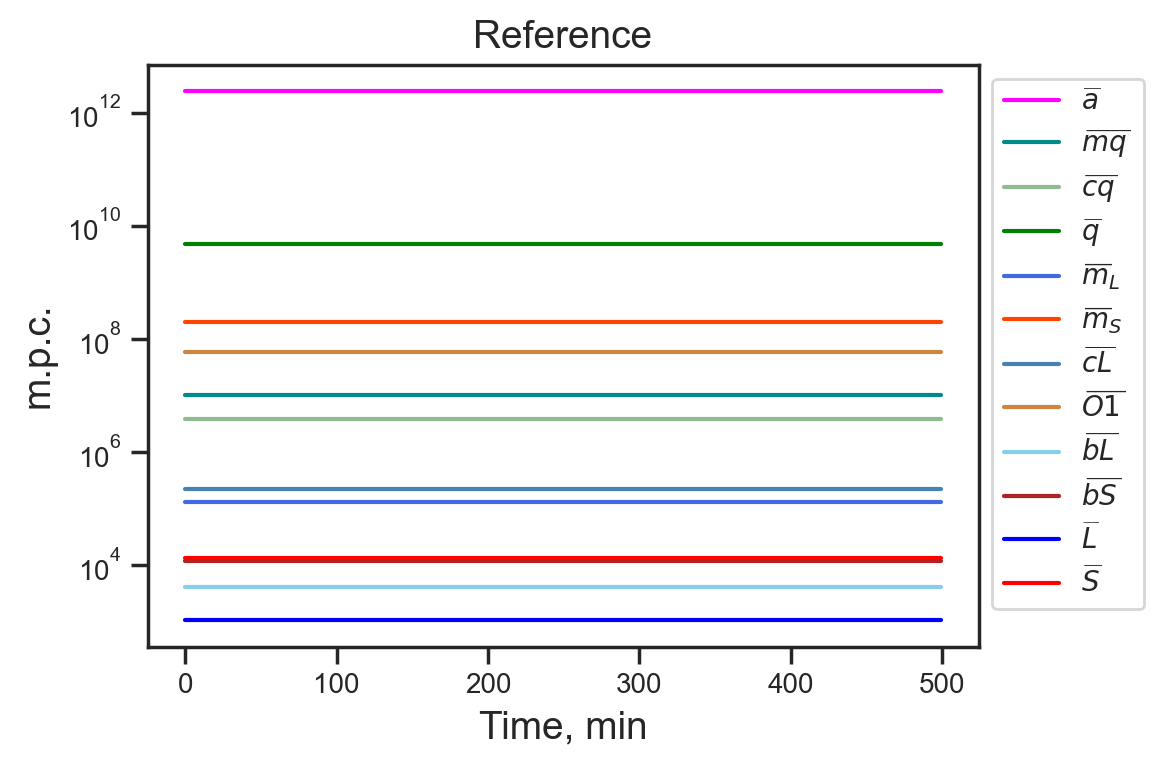

In [13]:
# Reference solution
t_start = 0.
t_finish = 500.
step = 1.
t_span = np.array([t_start, t_finish])
t = np.arange(t_start,t_finish,step)
n0 = 0
n = 500 #int((t_finish-t_start)/step)

# set initial conditions (random)
incond = root0.x.copy()
# seed = 12345
# rng = np.random.default_rng(seed)
# rfloat = rng.random(12)
# incond += incond*(rfloat*2-1)*0.8
# incond[-2] *=1000

# integrate
sol = integrate.solve_ivp(integr_syst, t_span, incond, t_eval=t, dense_output=True, method = 'Radau')

# Plot solution
fig, ax = plt.subplots()

ax.plot(sol.t[n0:n], sol.y[0,n0:n], '-', lw=1.5, color=colormap[0], label=r"$\widebar{a}$")
ax.plot(sol.t[n0:n], sol.y[1,n0:n], '-', lw=1.5, color=colormap[1], label=r"$\widebar{mq}$")
ax.plot(sol.t[n0:n], sol.y[2,n0:n], '-', lw=1.5, color=colormap[2], label=r"$\widebar{cq}$")
ax.plot(sol.t[n0:n], sol.y[3,n0:n], '-', lw=1.5, color=colormap[3], label=r"$\widebar{q}$")
ax.plot(sol.t[n0:n], sol.y[4,n0:n], '-', lw=1.5, color=colormap[4], label=r"$\widebar{m}_L$")
ax.plot(sol.t[n0:n], sol.y[5,n0:n], '-', lw=1.5, color=colormap[5], label=r"$\widebar{m}_S$")
ax.plot(sol.t[n0:n], sol.y[6,n0:n], '-', lw=1.5, color=colormap[6], label=r"$\widebar{cL}$")
ax.plot(sol.t[n0:n], sol.y[7,n0:n], '-', lw=1.5, color=colormap[7], label=r"$\widebar{O1}$")
ax.plot(sol.t[n0:n], sol.y[8,n0:n], '-', lw=1.5, color=colormap[8], label=r"$\widebar{bL}$")
ax.plot(sol.t[n0:n], sol.y[9,n0:n], '-', lw=1.5, color=colormap[9], label=r"$\widebar{bS}$")
ax.plot(sol.t[n0:n], sol.y[10,n0:n],'-', lw=1.5, color=colormap[10], label=r"$\widebar{L}$")
ax.plot(sol.t[n0:n], sol.y[11,n0:n],'-', lw=1.5, color=colormap[11], label=r"$\widebar{S}$")

# Label axes
ax.set_title('Reference')
ax.set_xlabel('Time, min')
ax.set_ylabel('m.p.c.')
ax.set_yscale('log')
ax.axis('auto')
ax.legend(bbox_to_anchor=[1.,1])
plt.tight_layout()
plt.show()

## Check knocked-S model

In [14]:
# Function for minimization
def solve_syst_knock_S(y):
    a_,mq_,cq_,q_,mL_,cL_,O1_,bL_,L_ = y
    dydt = np.array([ A0 - lmd_a*a_ - vreplf(a_,bL_,O1_,0.) # energy supply + ATP degradation + replication
                   - Nnt * ( om_q(a_)*(nQ) + om_L(L_,a_)*nL ) # transcription
                   - Naa * ( vq(cq_,a_)*nq + vL(cL_,a_)*(nL/3) ) # translation
                   - Nnt * ( vintL(bL_,O1_,a_)*nL ), # integration # da/dt
                    om_q(a_) - k_bq*ribf(cq_,cL_)*mq_ + k_uq*cq_ + vq(cq_,a_) - d_mq*mq_, # dmq/dt
                    k_bq*ribf(cq_,cL_)*mq_  - k_uq*cq_ - vq(cq_,a_) - d_cq*cq_, # dcq/dt
                    vq(cq_,a_) - d_q*q_, # dq/dt
                    om_L(L_,a_) - k_bL*ribf(cq_,cL_)*mL_ + k_uL*cL_ - d_mL*mL_, # dmL/dt
                    k_bL*ribf(cq_,cL_)*mL_  - k_uL*cL_ - vL(cL_,a_) - d_cL*cL_, # dcL/dt
                    vL(cL_,a_) - vintL(bL_,O1_,a_) - d_O1*O1_, # dO1/dt
                    vL(cL_,a_) - vintL(bL_,O1_,a_) - d_bL*bL_, # dbL/dt
                    vintL(bL_,O1_,a_) - lmd_L*L_ # dL/dt
           ])
    return dydt

# Function for integration
def integr_syst_knock_S(t, y):
    a_,mq_,cq_,q_,mL_,cL_,O1_,bL_,L_ = y
    dydt = np.array([ A0 - lmd_a*a_ - vreplf(a_,bL_,O1_,0.) # energy supply + ATP degradation + replication
                   - Nnt * ( om_q(a_)*(nQ) + om_L(L_,a_)*nL ) # transcription
                   - Naa * ( vq(cq_,a_)*nq + vL(cL_,a_)*(nL/3) ) # translation
                   - Nnt * ( vintL(bL_,O1_,a_)*nL ), # integration # da/dt
                    om_q(a_) - k_bq*ribf(cq_,cL_)*mq_ + k_uq*cq_ + vq(cq_,a_) - d_mq*mq_, # dmq/dt
                    k_bq*ribf(cq_,cL_)*mq_  - k_uq*cq_ - vq(cq_,a_) - d_cq*cq_, # dcq/dt
                    vq(cq_,a_) - d_q*q_, # dq/dt
                    om_L(L_,a_) - k_bL*ribf(cq_,cL_)*mL_ + k_uL*cL_ - d_mL*mL_, # dmL/dt
                    k_bL*ribf(cq_,cL_)*mL_  - k_uL*cL_ - vL(cL_,a_) - d_cL*cL_, # dcL/dt
                    vL(cL_,a_) - vintL(bL_,O1_,a_) - d_O1*O1_, # dO1/dt
                    vL(cL_,a_) - vintL(bL_,O1_,a_) - d_bL*bL_, # dbL/dt
                    vintL(bL_,O1_,a_) - lmd_L*L_ # dL/dt
           ])
    return dydt

In [15]:
incond = np.array([4.45330083e+09, 5.01078199e+06, 2.42674665e+06, 2.97908462e+09,
       1.03404963e+05, 2.19353478e+05, 2.35091844e+05, 2.35091844e+05,
       6.18293081e+04]) # knock-S

root1 = root(solve_syst_knock_S, incond, method='lm', options={'maxiter':10000})
print("success:", root1.success)
print("niter =", root1.nfev)
print(root1.x)

success: True
niter = 11
[4.45330083e+09 5.01078199e+06 2.42674665e+06 2.97908462e+09
 1.03404963e+05 2.19353478e+05 2.35091844e+05 2.35091844e+05
 6.18293081e+04]


In [16]:
# Check with least_squares
incond = root1.x
lsq = least_squares(solve_syst_knock_S, incond, method='dogbox', bounds=(0, np.inf), max_nfev=25)
print("message:", lsq.message)
print("success:", lsq.success)
print("niter =", lsq.nfev)
print("root:\n", lsq.x)
print("O-C:\n", solve_syst_knock_S(lsq.x))

message: `xtol` termination condition is satisfied.
success: True
niter = 2
root:
 [4.45330083e+09 5.01078199e+06 2.42674665e+06 2.97908462e+09
 1.03404963e+05 2.19353478e+05 2.35091844e+05 2.35091844e+05
 6.18293081e+04]
O-C:
 [ 1.43051147e-06  3.93811206e-10 -3.93356459e-10  0.00000000e+00
  9.52127266e-12 -7.84439180e-12  5.57065505e-12  5.57065505e-12
 -7.27595761e-12]


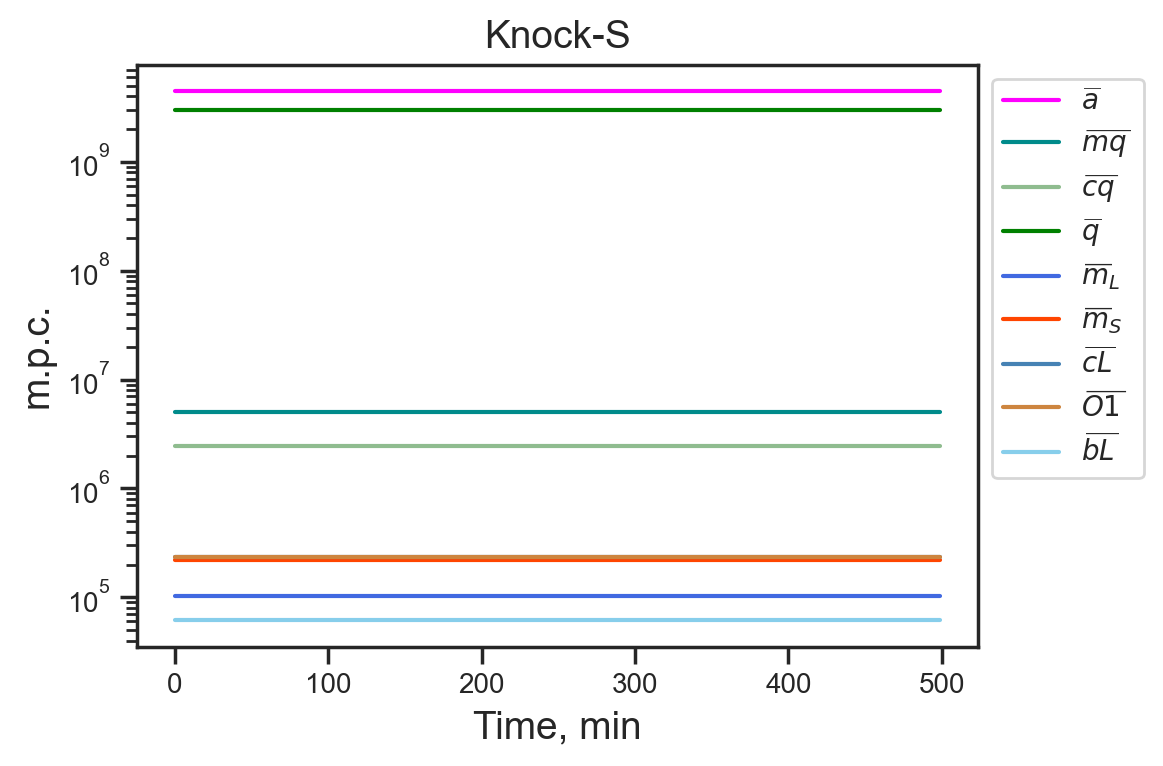

In [17]:
# Reference solution
t_start = 0.
t_finish = 1000.
step = 1.
t_span = np.array([t_start, t_finish])
t = np.arange(t_start,t_finish,step)
n0 = 0
n = 500 #int((t_finish-t_start)/step)

# set initial conditions
incond = root1.x.copy()

# integrate
sol = integrate.solve_ivp(integr_syst_knock_S, t_span, incond, t_eval=t, dense_output=True, method = 'Radau')

# Plot solution
fig, ax = plt.subplots()

ax.plot(sol.t[n0:n], sol.y[0,n0:n], '-', lw=1.5, color=colormap[0], label=r"$\widebar{a}$")
ax.plot(sol.t[n0:n], sol.y[1,n0:n], '-', lw=1.5, color=colormap[1], label=r"$\widebar{mq}$")
ax.plot(sol.t[n0:n], sol.y[2,n0:n], '-', lw=1.5, color=colormap[2], label=r"$\widebar{cq}$")
ax.plot(sol.t[n0:n], sol.y[3,n0:n], '-', lw=1.5, color=colormap[3], label=r"$\widebar{q}$")
ax.plot(sol.t[n0:n], sol.y[4,n0:n], '-', lw=1.5, color=colormap[4], label=r"$\widebar{m}_L$")
ax.plot(sol.t[n0:n], sol.y[5,n0:n], '-', lw=1.5, color=colormap[5], label=r"$\widebar{m}_S$")
ax.plot(sol.t[n0:n], sol.y[6,n0:n], '-', lw=1.5, color=colormap[6], label=r"$\widebar{cL}$")
ax.plot(sol.t[n0:n], sol.y[7,n0:n], '-', lw=1.5, color=colormap[7], label=r"$\widebar{O1}$")
ax.plot(sol.t[n0:n], sol.y[8,n0:n], '-', lw=1.5, color=colormap[8], label=r"$\widebar{bL}$")

# Label axes
ax.set_title('Knock-S')
ax.set_xlabel('Time, min')
ax.set_ylabel('m.p.c.')
ax.set_yscale('log')
ax.axis('auto')
ax.legend(bbox_to_anchor=[1.,1])
plt.tight_layout()
plt.show()